# SYDE556/750 Assignment 3: Connecting Neurons

- Due Date: March 6th
- Total marks: 10 (10% of final grade)
- Late penalty: 1 mark per day
- It is recommended that you Python.
- Do not use any code from Nengo

## 1) Decoding from a population

As you did in previous assignments, make a population of 20 LIF neurons representing a 1-dimensional value, and compute a decoder for them.  For parameters, $\tau_{ref}$=0.002s, $\tau_{RC}$=0.02s, the maximum firing rates are chosen randomly from a uniform distribution between 100 and 200Hz (at the max radius), and the x-intercepts are chosen randomly from a uniform distribution between -2 and 2.  Remember that the $\alpha$ and $J^{bias}$ terms are computed based on these x-intercepts and maximum firing rates.

It is generally easiest to compute decoders using the original method from Assignment 1, where we use the rate-mode approximation for the neurons to generate the $A$ matrix, then find $\Gamma=A^T A + \sigma^2 I$.  You can use this approach to find decoders, and these decoders should work even when you simulate the neurons in terms of spikes (in question 2 on).  The only difference will be that they will need to be scaled by ``dt``, your simulation time step.

Use method for computing decoders for this whole assignment.

<ol style="list-style:lower-alpha outside none;" start="1">
<li>[0.5 marks] Plot the tuning curves (firing rate of each neuron for different $x$ values between -2 and 2)</li>
</ol>

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import numpy

In [2]:
class LIFNeuron:
    
    def __init__(self, tau_ref=0.002, tau_rc=0.02, min_rate=100, max_rate=200, alpha=None, j_bias=None):
        self.x_int = np.random.uniform(-2,2)
        self.min_rate = min_rate
        self.max_rate = max_rate
        self.tau_ref = tau_ref
        self.tau_rc = tau_rc
        self.encoder = np.random.choice([1,-1])
        firing_rate = np.random.uniform(self.min_rate, self.max_rate)
        J_max = 1/(1 - np.exp((self.tau_ref - 1/firing_rate)/self.tau_rc))
        self.alpha = (J_max - 1)/(2 - self.encoder*self.x_int)
        self.j_bias = 1 - self.alpha*self.encoder*self.x_int
    
    def set_alpha_jbias_enc(self, alpha, jbias, enc):
        self.encoder = enc
        self.alpha = alpha
        self.j_bias = jbias
            
    def get_spikes(self, x, dt):
        number_of_spikes = 0
        spikes = []
        val,i = 0,0
        while i < len(x):
            J = self.alpha*x[i]*self.encoder + self.j_bias
            if val >= 1:
                val = 1.5
                number_of_spikes +=1
                if len(spikes) < len(x): spikes.append(val)
                val,j = 0,0
                while(j<np.floor(self.tau_ref/dt)):
                    i,j=i+1,j+1
                    if len(spikes) < len(x): spikes.append(val)
                val = val + dt*(1/self.tau_rc)*(J - val)
                i += 1        
                continue
            elif val < 0:
                val = 0
                if len(spikes) < len(x): spikes.append(val)
            else:    
                if len(spikes) < len(x): spikes.append(0)
            
            val = val + dt*(1/self.tau_rc)*(J - val)
            i += 1        
        return number_of_spikes, spikes
    
    def get_rates(self, x):
        r = []
        for i in range(len(x)):
            rate = 0
            J = self.alpha*x[i]*self.encoder+self.j_bias
            if J > 1:
                rate = 1/(self.tau_ref - self.tau_rc*np.log(1 - 1/J))
            r.append(rate)        
        return r

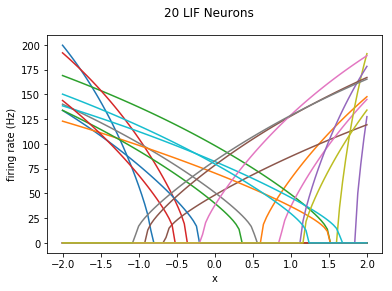

In [3]:
dt = 0.001

plt.figure()
plt.suptitle('20 LIF Neurons')

num_neurons = 20
number_of_samples = 101
x = np.linspace(-2,2,number_of_samples)

neurons = []
my_rates = []
for i in range(num_neurons):
    n = LIFNeuron()
    neurons.append(n)
    my_rates.append(n.get_rates(x))

for i in range(len(my_rates)):
    plt.plot(x,my_rates[i])

plt.xlabel('x')
plt.ylabel('firing rate (Hz)')
plt.show()

<ol style="list-style:lower-alpha outside none;" start="2">
<li> [0.5 marks] Compute the decoders and plot $(x-\hat{x})$.  When computing decoders, take into account noise ($\sigma$=0.1 times 200Hz).  When computing $\hat{x}$, add random gaussian noise with $\sigma$=0.1 times 200Hz to the activity. Report the Root Mean-Squared Error (RMSE).</li>
</ol>

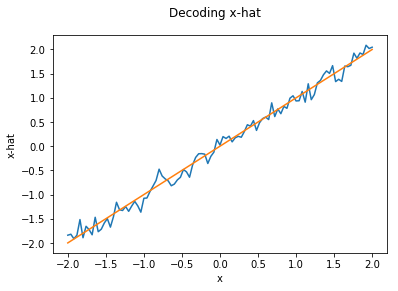

In [4]:
sigma=0.1*200
A = np.array(my_rates).T
g = np.dot(np.transpose(A),A)/number_of_samples + np.power(sigma,2)*np.identity(A.shape[1])
u = np.dot(np.transpose(A),x)/number_of_samples
d = np.dot(np.linalg.inv(g),u)

g_noise = np.random.normal(scale=sigma,size=np.shape(A))
x_hat = np.dot(A + g_noise,d)

plt.figure()
plt.suptitle('Decoding x-hat')
plt.plot(x,x_hat)
plt.plot(x,x)
plt.xlabel('x')
plt.ylabel('x-hat')
plt.show()

## 2) Decoding from two spiking neurons

Choose a neuron from part 1 that has a firing rate of somewhere between 20-50Hz for $x$=0.  Using that neuron's $\alpha$ and $J^{bias}$ value, construct two neurons: both with the same $\alpha$ and $J^{bias}$, but one with $e$=+1 and the other with $e$=-1.  With the function from the last assignment, generate a random input $x(t)$ that is 1 second long, with rms=1, dt=0.001, and an upper limit of 5Hz.  Feed that signal into the two neurons and generate spikes.  Decode the spikes back into $\hat{x}(t)$ using a post-synaptic current filter $h(t)$ with a time constant of $\tau$=0.005.

In [5]:
tau = 0.005

def generate_ht(t, n, tau):
    h = t**n * np.exp(-t/tau)
    h = h/np.linalg.norm(h,1)
    return h

def generate_ht2(t, n, tau):
    h = t**n * np.exp(-t/tau)
    h[np.where(t<0)]=0
    h = h/np.linalg.norm(h,1)
    return h


def generate_signal(T, dt, rms, limit, seed=0):
    np.random.seed(seed=seed)
    number_of_samples = int(T/dt)
    frequencies=np.arange(number_of_samples)/T - number_of_samples/(2*T)
    X = np.zeros(len(frequencies)).tolist()
    
    for i, f in enumerate(frequencies):
        if abs(f) <= limit:
            real, imag = np.random.normal(), np.random.normal()*1j
            X[i] = real + imag
            if f < 0: X[i] = real - imag
       
    x =np.fft.ifft(np.fft.ifftshift(X)).real
    x_rms = np.sqrt(np.mean(np.power(x,2)))
    x = [val*rms/(x_rms) for val in x]
    X = np.fft.fftshift(numpy.fft.fft(x))   
    return x,X

index_of_x_zero = np.where(x==0)[0][0]

neuron_20_50 = None
for i in range(len(A[index_of_x_zero])):
    val = A[index_of_x_zero][i]
    if val>=20 and val<=50:
        neuron_20_50 = neurons[i]
        break
        
neuron_1 = LIFNeuron()
neuron_1.set_alpha_jbias_enc(neuron_20_50.alpha, neuron_20_50.j_bias, 1)
neuron_2 = LIFNeuron()
neuron_2.set_alpha_jbias_enc(neuron_20_50.alpha, neuron_20_50.j_bias, -1)

T, rms, dt, limit = 1, 1, 0.001, 5
t = np.arange(0,T,dt)
x_generated, X = generate_signal(T=T,rms=rms,dt=dt,limit=limit)


spikes = []
_, s = neuron_1.get_spikes(x_generated,dt)
spikes.append(s)
_, s = neuron_2.get_spikes(x_generated,dt)
spikes.append(s)

<ol style="list-style:lower-alpha outside none;" start="1">
<li>[0.5 marks] Plot the post-synaptic current $h(t)=e^{-t/\tau}/ \int e^{-t/\tau} dt$</li>
</ol>

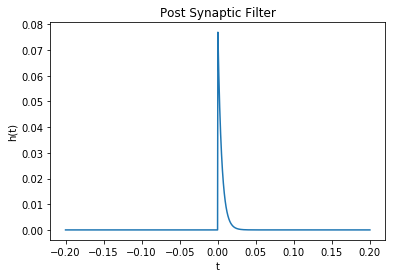

In [6]:
t = np.linspace(-0.2, 0.2, 1000)
h = generate_ht2(t, 0, tau)
plt.title('Post Synaptic Filter')
plt.xlabel('t')
plt.ylabel('h(t)')
plt.plot(t,h)
plt.show()

<ol style="list-style:lower-alpha outside none;" start="2">
<li>[0.5 marks] Plot the original signal $x(t)$, the spikes, and the decoded $\hat{x}(t)$ all on the same graph</li>
</ol>

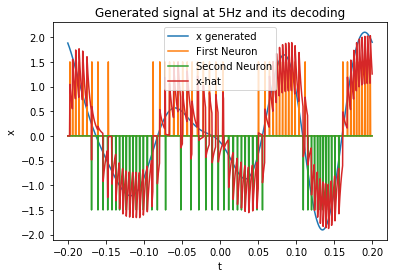

In [7]:
def my_convolution(spikes, ht):
    f_spikes = np.zeros(len(spikes))
    for i in range(len(spikes)):
        if spikes[i] >= 1:
            j=i
            while(j<len(spikes)):
                f_spikes[j]=f_spikes[j]+ht[j-i]
                j=j+1
    return np.array(f_spikes)    




rates = []
rates.append(neuron_1.get_rates(x_generated))
rates.append(neuron_2.get_rates(x_generated))


sigma = 0.1*200
A = np.array(rates).T
g = np.dot(np.transpose(A),A)/number_of_samples + np.power(sigma,2)*np.identity(A.shape[1])
u = np.dot(np.transpose(A),x_generated)/number_of_samples
d = np.dot(np.linalg.inv(g),u)

h = generate_ht(t, 0, tau)
filtered_spikes_1 = my_convolution(spikes[0], h)
filtered_spikes_2 = my_convolution(spikes[1], h)

A = np.array([filtered_spikes_1, filtered_spikes_2]).T
xhat = np.dot(A/dt,d)


plt.title('Generated signal at 5Hz and its decoding')
plt.plot(t,x_generated,label='x generated')
plt.xlabel('t')
plt.ylabel('x')
plt.plot(t,spikes[0],label='First Neuron')
plt.plot(t,[-1*spike for spike in spikes[1]],label='Second Neuron')
plt.plot(t,xhat, label='x-hat')
plt.legend()
plt.show()

<ol style="list-style:lower-alpha outside none;" start="3">
<li>[0.5 marks] Compute the RMSE of the decoding</li>
</ol>

In [8]:
print('RMSE:', np.sqrt(np.mean(np.power(x_generated - xhat,2))))

RMSE: 0.49279475752786517


## 3) Decoding from many neurons

Repeat question 2, but with more neurons.  Instead of picking particular neurons, randomly generate them with x-intercepts uniformly distributed between -2 and 2 and with maximum firing rates between 100 and 200 Hz.  Randomly choose encoder values to be either -1 or +1.

<ol style="list-style:lower-alpha outside none;" start="1">
<li>[2 marks] Plot Root Mean-Squared Error as the number of neurons increases, on a log plot.  Try 8 neurons, 16 neurons, 32, 64, 128, up to 256.  For the RMSE for a particular number of neurons, average over at least 5 randomly generated groups of neurons.  For each group of neurons, randomly generate the signal $x(t)$.  Use the same parameters as in question 2. Note: the RMSE should go down as the number of neurons increases</li>
</ol>

In [9]:
num_of_neurons = [8,16,32,64,128,256]
T, rms, dt, limit = 1, 1, 0.001, 5
rmse = []

for val in num_of_neurons:

    neurons = []
    for i in range(val):
        neurons.append(LIFNeuron())
    
    sum_rms = 0
    for _ in range(5):
        x_generated, X = generate_signal(T=T,rms=rms,dt=dt,limit=limit)
        rates = []
        spikes = []
        for neuron in neurons:
            rates.append(neuron.get_rates(x_generated))
            _, s = neuron.get_spikes(x_generated,dt)
            spikes.append(s)
        
        sigma = 0.1*200
        A = np.array(rates).T
        g = np.dot(np.transpose(A),A)/number_of_samples + np.power(sigma,2)*np.identity(A.shape[1])
        u = np.dot(np.transpose(A),x_generated)/number_of_samples
        d = np.dot(np.linalg.inv(g),u)
        
        filtered_spikes = [my_convolution(spike, h) for spike in spikes]
        A = np.array(filtered_spikes).T
        xhat = np.dot(A/dt,d)
        
        sum_rms += np.sqrt(np.mean(np.power(x_generated - xhat,2)))
    rmse.append(sum_rms/5)

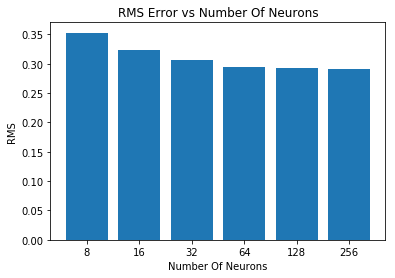

RMSE
0.35302081115078787
0.32273202130321665
0.30572371274898913
0.2951614933423746
0.2927516095363019
0.29187252174898937


In [10]:
plt.bar(np.log2(num_of_neurons),rmse, tick_label=num_of_neurons)
plt.title("RMS Error vs Number Of Neurons")
plt.xlabel("Number Of Neurons")
plt.ylabel("RMS")
plt.show();

print('RMSE')
for val in rmse:
    print(val) 

## 4) Connecting two groups of neurons

For this question, use two groups of neurons with intercepts between [-1, 1] to compute $y = 2x+1$.  The first group of neurons will represent $x$ and the second group will represent $y$.

Start by computing decoders.  You will need two decoders: one to decode $f(x)=2x+1$ from the first population, and one to decode $f(y)=y$ (the standard representational decoder) from the second population.  Remember that $\Upsilon$ can change depending on what function you want to decode.

Use the same neuron parameters as for previous questions, and use 200 randomly generated neurons in each population.

<ol style="list-style:lower-alpha outside none;" start="1">
<li>[1 mark] Show the behaviour of the system with an input of $x(t)=t-1$ for 1 second (a linear ramp from -1 to 0).  Plot the ideal $x(t)$ and $y(t)$ values, along with $\hat{y}(t)$.</li>
<ul>
<li>Note that you should use the decoders that work for any input over the range of intercepts: do not re-compute decoders for any particular input (i.e. set of $x$ values).</li>
<li>Input $x(t)$ into the first group of neurons and produce spikes.  Decode from those spikes using the decoder for $f(x)=2x+1$.  Input that decoded result into the second group of neurons to produce spikes.  Use the second decoder ($f(y)=y$) to decode $\hat{y}(t)$.</li>
</ul>

In [11]:
total_no_neurons = 200
t = np.arange(0,T,dt)
sigma = 0.1*200

neurons_x = [LIFNeuron() for _ in range(total_no_neurons)]
neurons_y = [LIFNeuron() for _ in range(total_no_neurons)]

sig_one = np.linspace(-2,2,len(t))
sig_two = [2*k+1 for k in sig_one]

rates_x = [n.get_rates(sig_one) for n in neurons_x]
A_x = np.array(rates_x).T
g = np.dot(A_x.T,A_x)/number_of_samples + np.power(sigma,2)*np.identity(A_x.shape[1])
u = np.dot(A_x.T,sig_two)/number_of_samples
d_x = np.dot(np.linalg.inv(g),u)

rates_y = [n.get_rates(sig_one) for n in neurons_y]
A_y = np.array(rates_y).T
g = np.dot(A_y.T,A_y)/number_of_samples + np.power(sigma,2)*np.identity(A_y.shape[1])
u = np.dot(A_y.T,sig_one)/number_of_samples
d_y = np.dot(np.linalg.inv(g),u)

x = np.linspace(-1,0,len(t))
y = [2*k+1 for k in x]

spikes_x = []
for neuron in neurons_x:
    _, s = neuron.get_spikes(x,dt)
    spikes_x.append(s)

filtered_spikes_x = [my_convolution(s, h) for s in spikes_x]
A = np.array(filtered_spikes_x).T
xhat = np.dot(A/dt,d_x)

spikes_y = []
for neuron in neurons_y:
    _, s = neuron.get_spikes(xhat,dt)
    spikes_y.append(s)

filtered_spikes_y = [my_convolution(s, h) for s in spikes_y]
A = np.array(filtered_spikes_y).T
yhat = np.dot(A/dt,d_y)

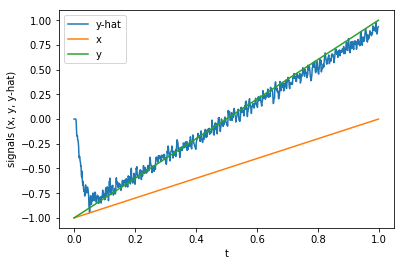

In [12]:
plt.plot(t,yhat,label='y-hat')
plt.plot(t,x,label='x')
plt.plot(t,y,label='y')
plt.xlabel('t')
plt.ylabel('signals (x, y, y-hat)')
plt.legend()
plt.show()

<ol style="list-style:lower-alpha outside none;" start="2">
<li>[0.5 marks] Repeat part (a) with an input that is ten randomly chosen values between -1 and 0, each one held for 0.1 seconds (a randomly varying step input)</li>
</ol>

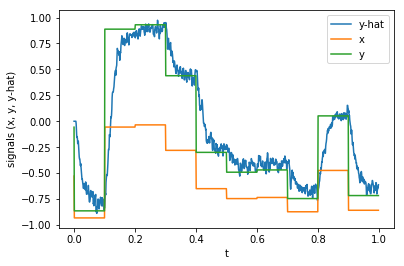

In [13]:
x = []
val = np.random.uniform(-1,0)
for i in range(len(t)):
    x.append(val)
    if i%100==0: 
        val = np.random.uniform(-1,0)
    
y = [2*k+1 for k in x]

spikes_x = []
for neuron in neurons_x:
    _, s = neuron.get_spikes(x,dt)
    spikes_x.append(s)

filtered_spikes_x = [my_convolution(s, h) for s in spikes_x]
A = np.array(filtered_spikes_x).T
xhat = np.dot(A/dt,d_x)
   

spikes_y = []
for neuron in neurons_y:
    _, s = neuron.get_spikes(xhat,dt)
    spikes_y.append(s)

filtered_spikes_y = [my_convolution(s, h) for s in spikes_y]
A = np.array(filtered_spikes_y).T
yhat = np.dot(A/dt,d_y)


plt.plot(t,yhat,label='y-hat')
plt.plot(t,x,label='x')
plt.plot(t,y,label='y')
plt.xlabel('t')
plt.ylabel('signals (x, y, y-hat)')
plt.legend()
plt.show()

<ol style="list-style:lower-alpha outside none;" start="3">
<li>[0.5 marks] Repeat part (a) with an input that is $x(t)=0.2sin(6\pi t)$. Briefly discuss the results for this question.</li>
</ol>

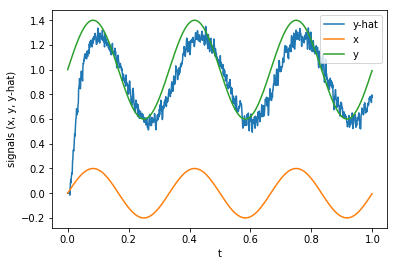

In [14]:
total_no_neurons = 200
t = np.arange(0,T,dt)
sigma = 0.1*200

neurons_x = [LIFNeuron() for _ in range(total_no_neurons)]
neurons_y = [LIFNeuron() for _ in range(total_no_neurons)]

sig_one = np.linspace(-2,2,len(t))
sig_two = [2*k+1 for k in sig_one]

rates_x = [n.get_rates(sig_one) for n in neurons_x]
A_x = np.array(rates_x).T
g = np.dot(A_x.T,A_x)/number_of_samples + np.power(sigma,2)*np.identity(A_x.shape[1])
u = np.dot(A_x.T,sig_two)/number_of_samples
d_x = np.dot(np.linalg.inv(g),u)

rates_y = [n.get_rates(sig_one) for n in neurons_y]
A_y = np.array(rates_y).T
g = np.dot(A_y.T,A_y)/number_of_samples + np.power(sigma,2)*np.identity(A_y.shape[1])
u = np.dot(A_y.T,sig_one)/number_of_samples
d_y = np.dot(np.linalg.inv(g),u)

x = 0.2*np.sin(6*np.pi*t)
y = [2*k+1 for k in x]

spikes_x = []
for neuron in neurons_x:
    _, s = neuron.get_spikes(x,dt)
    spikes_x.append(s)

filtered_spikes_x = [my_convolution(s, h) for s in spikes_x]
A = np.array(filtered_spikes_x).T
xhat = np.dot(A/dt,d_x)

spikes_y = []
for neuron in neurons_y:
    _, s = neuron.get_spikes(xhat,dt)
    spikes_y.append(s)

filtered_spikes_y = [my_convolution(s, h) for s in spikes_y]
A = np.array(filtered_spikes_y).T
yhat = np.dot(A/dt,d_y)

plt.plot(t,yhat,label='y-hat')
plt.plot(t,x,label='x')
plt.plot(t,y,label='y')
plt.xlabel('t')
plt.ylabel('signals (x, y, y-hat)')
plt.legend()
plt.show()

At t=0, the rms error is huge in the starting, that is because neurons have no information in begining to deal with. As the signal is processed to few 100 miliseconds, it improves drastically, the improvement in that duration is huge due to lots of new information. Also, there is a shift in decoded y hat, thats because of post synaptic filter which causes little lag. In addition, noisy xhat wah given as input to second neuron population and then yhat is produced, which was bit less noisy because the noise was taken into account while decoding as well.

## 5) Connecting three groups of neurons

For this question, use three groups of neurons with intercepts from [-1, 1] to compute $z = 2y+0.5x$.  Follow the same steps as question 4, but take the decoded outputs from the first two groups of neurons ($f(y)=2y$ and $f(x)=0.5x$), add them together, and feed that into the third group of neurons.

<ol style="list-style:lower-alpha outside none;" start="1">
<li>[1 mark] Plot $x(t)$, $y(t)$, the ideal $z(t)$, and the decoded $\hat{z}(t)$ for an input of $x(t)=cos(3\pi t)$ and $y(t)=0.5 sin (2 \pi t)$ (over 1.0 seconds)</li>
</ol>

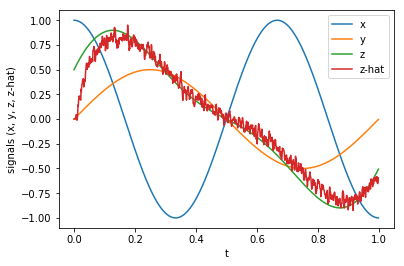

In [15]:
total_no_neurons = 200
t = np.arange(0,T,dt)
sigma = 0.1*200

neurons_x = [LIFNeuron() for _ in range(total_no_neurons)]
neurons_y = [LIFNeuron() for _ in range(total_no_neurons)]
neurons_z = [LIFNeuron() for _ in range(total_no_neurons)]


sig_one = np.linspace(-2,2,len(t))
sig_two = [2*k for k in sig_one]
sig_three = [0.5*k for k in sig_one]
        
    
rates_x = [n.get_rates(sig_one) for n in neurons_x]
A_x = np.array(rates_x).T
g = np.dot(A_x.T,A_x)/number_of_samples + np.power(sigma,2)*np.identity(A_x.shape[1])
u = np.dot(A_x.T,sig_three)/number_of_samples
d_x = np.dot(np.linalg.inv(g),u)


rates_y = [n.get_rates(sig_one) for n in neurons_y]
A_y = np.array(rates_y).T
g = np.dot(A_y.T,A_y)/number_of_samples + np.power(sigma,2)*np.identity(A_y.shape[1])
u = np.dot(A_y.T,sig_two)/number_of_samples
d_y = np.dot(np.linalg.inv(g),u)


rates_z = [n.get_rates(sig_one) for n in neurons_z]
A_z = np.array(rates_z).T
g = np.dot(A_z.T,A_z)/number_of_samples + np.power(sigma,2)*np.identity(A_z.shape[1])
u = np.dot(A_z.T,sig_one)/number_of_samples
d_z = np.dot(np.linalg.inv(g),u)


x = np.cos(3*np.pi*t)
y = 0.5*np.sin(2*np.pi*t)
z = [0.5*pair[0] + 2*pair[1] for pair in zip(x,y)]


spikes_x = []
for neuron in neurons_x:
    _, s = neuron.get_spikes(x,dt)
    spikes_x.append(s)
filtered_spikes_x = [my_convolution(s, h) for s in spikes_x]
A = np.array(filtered_spikes_x).T
xhat = np.dot(A/dt,d_x)


spikes_y = []
for neuron in neurons_y:
    _, s = neuron.get_spikes(y,dt)
    spikes_y.append(s)
filtered_spikes_y = [my_convolution(s, h) for s in spikes_y]
A = np.array(filtered_spikes_y).T
yhat = np.dot(A/dt,d_y)


xy = [pair[0] + pair[1] for pair in zip(xhat,yhat)]


spikes_z = []
for neuron in neurons_z:
    _, s = neuron.get_spikes(xy,dt)
    spikes_z.append(s)
filtered_spikes_z = [my_convolution(s, h) for s in spikes_z]
A = np.array(filtered_spikes_z).T
zhat = np.dot(A/dt,d_z)



plt.plot(t,x,label='x')
plt.plot(t,y,label='y')
plt.plot(t,z,label='z')
plt.plot(t,zhat,label='z-hat')
plt.xlabel('t')
plt.ylabel('signals (x, y, z, z-hat)')
plt.legend()
plt.show()

<ol style="list-style:lower-alpha outside none;" start="2">
<li>[0.5 marks] Plot $x(t)$, $y(t)$, the ideal $z(t)$, and the decoded $\hat{z}(t)$ for a random input over 1 second.  For $x(t)$ use a random signal with a limit of 8 Hz and `rms`=1.  For $y(t)$ use a random signal with a limit of 5 Hz and `rms`=0.5.</li>
</ol>

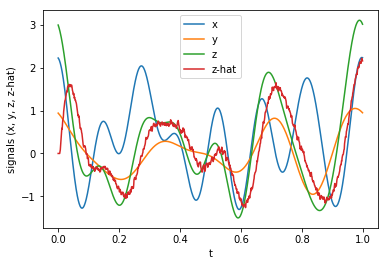

In [16]:
x, _ = generate_signal(T=T,dt=dt,rms=1,limit=8)
y, _ = generate_signal(T=T,dt=dt,rms=0.5,limit=5)
z = [0.5*pair[0] + 2.0*pair[1] for pair in zip(x,y)]



spikes_x = []
for neuron in neurons_x:
    _, s = neuron.get_spikes(x,dt)
    spikes_x.append(s)
filtered_spikes_x = [my_convolution(s, h) for s in spikes_x]
A = np.array(filtered_spikes_x).T
xhat = np.dot(A/dt,d_x)


spikes_y = []
for neuron in neurons_y:
    _, s = neuron.get_spikes(y,dt)
    spikes_y.append(s)
filtered_spikes_y = [my_convolution(s, h) for s in spikes_y]
A = np.array(filtered_spikes_y).T
yhat = np.dot(A/dt,d_y)


xy = [pair[0] + pair[1] for pair in zip(xhat,yhat)]


spikes_z = []
for neuron in neurons_z:
    _, s = neuron.get_spikes(xy,dt)
    spikes_z.append(s)
filtered_spikes_z = [my_convolution(s, h) for s in spikes_z]
A = np.array(filtered_spikes_z).T
zhat = np.dot(A/dt,d_z)

plt.plot(t,x,label='x')
plt.plot(t,y,label='y')
plt.plot(t,z,label='z')
plt.plot(t,zhat,label='z-hat')
plt.xlabel('t')
plt.ylabel('signals (x, y, z, z-hat)')
plt.legend()
plt.show()

## 6) Computing with vectors

Do the same thing as questions 4 and 5, but with 2-dimensional vectors instead of scalars.  Everything else is the same.  For your encoders $e$, randomly generate them over the unit circle.  

The function to compute is $w = x-3y+2z-2q$.  This requires five groups of neurons: $x$, $y$, $z$, $q$, and $w$.  Each of them represents a 2-dimensional value.  The outputs from $x$, $y$, $z$, and $q$ all feed into $w$.

<ol style="list-style:lower-alpha outside none;" start="1">
<li>[1 mark] Plot the decoded output $\hat{w}(t)$ and the ideal $w$ for $x=[0.5,1], y=[0.1,0.3], z=[0.2,0.1], q = [0.4,-0.2]$.  (Note that these are all constants so they don't change over time, but still plot it for 1.0 seconds on one or more 2D graphs)</li>
</ol>

In [17]:
class LIF2DNeuron:
    
    def __init__(self, tau_ref=0.002, tau_rc=0.02, min_rate=100, max_rate=200):
        angle = np.random.uniform(0,2*np.pi)
        r = np.random.uniform(0,2)
        self.x_int = [r*np.cos(angle), r*np.sin(angle)]
        self.min_rate = min_rate
        self.max_rate = max_rate
        self.tau_ref = tau_ref
        self.tau_rc = tau_rc
        self.encoder = [np.cos(angle), np.sin(angle)]
        firing_rate = np.random.uniform(self.min_rate, self.max_rate)
        J_max = 1/(1 - np.exp((self.tau_ref - 1/firing_rate)/self.tau_rc))
        self.alpha = (J_max - 1)/(2 - np.vdot(self.encoder,self.x_int))
        self.j_bias = 1 - self.alpha*np.vdot(self.encoder,self.x_int)
            
    def get_spikes(self, x, dt):
        number_of_spikes = 0
        spikes = []
        val,i = 0,0
        while i < len(x):
            J = self.alpha*np.vdot(x[i],self.encoder) + self.j_bias
            if val >= 1:
                val = 1.5
                number_of_spikes +=1
                if len(spikes) < len(x): spikes.append(val)
                val,j = 0,0
                while(j<np.floor(self.tau_ref/dt)):
                    i,j=i+1,j+1
                    if len(spikes) < len(x): spikes.append(val)
                val = val + dt*(1/self.tau_rc)*(J - val)
                i += 1        
                continue
            elif val < 0:
                val = 0
                if len(spikes) < len(x): spikes.append(val)
            else:    
                if len(spikes) < len(x): spikes.append(0)
            
            val = val + dt*(1/self.tau_rc)*(J - val)
            i += 1        
        return number_of_spikes, spikes
    
    def get_rates(self, x):
        r = []
        for i in range(len(x)):
            rate = 0
            J = self.alpha*np.vdot(x[i],self.encoder)+self.j_bias
            if J > 1:
                rate = 1/(self.tau_ref - self.tau_rc*np.log(1 - 1/J))
            r.append(rate)        
        return r


In [18]:
x, y, z, q, sigma, total_no_neurons = [0.5,1],[0.1,0.3],[0.2,0.1],[0.4,-0.2], 0.1*200, 200

t = np.arange(0,T,dt)
w = [[x[0] -3*y[0] +2*z[0] -2*q[0], x[1] -3*y[1] +2*z[1] -2*q[1]] for _ in t]

X,Y = np.mgrid[-2:2:.04, -2:2:.04]
points=np.array([X.flatten(),Y.flatten()]).T


neurons_x = [LIF2DNeuron() for _ in range(total_no_neurons)]
rates_x = [n.get_rates(points) for n in neurons_x]
A_x = np.array(rates_x).T
g = np.dot(A_x.T,A_x)/number_of_samples + sigma*np.identity(A_x.shape[1])
u = np.dot(A_x.T,points)/number_of_samples
d_x = np.dot(np.linalg.inv(g),u)

X = [[x[0], x[1]] for _ in t]

spikes_x = []
for neuron in neurons_x:
    _, s = neuron.get_spikes(X,dt)
    spikes_x.append(s)

filtered_spikes_x = [my_convolution(s, h) for s in spikes_x]
A = np.array(filtered_spikes_x).T
xhat = np.dot(A/dt,d_x)

In [19]:
neurons_y = [LIF2DNeuron() for _ in range(total_no_neurons)]
rates_y = [n.get_rates(points) for n in neurons_y]

y_points = [[-3*point[0], -3*point[1]] for point in points]

A_y = np.array(rates_y).T
g = np.dot(np.transpose(A_y),A_y)/number_of_samples + sigma*np.identity(A_y.shape[1])
u = np.dot(np.transpose(A_y),y_points)/number_of_samples
d_y = np.dot(np.linalg.inv(g),u)

Y = [[y[0], y[1]] for _ in t]

spikes_y = []
for neuron in neurons_y:
    _, s = neuron.get_spikes(Y,dt)
    spikes_y.append(s)

filtered_spikes_y = [my_convolution(s, h) for s in spikes_y]
A = np.array(filtered_spikes_y).T
yhat = np.dot(A/dt,d_y)

In [20]:
neurons_z = [LIF2DNeuron() for _ in range(total_no_neurons)]
rates_z = [n.get_rates(points) for n in neurons_z]

z_points = [[2*point[0], 2*point[1]] for point in points]

A_z = np.transpose(rates_z)
g = np.dot(np.transpose(A_z),A_z)/number_of_samples + sigma*np.identity(A_z.shape[1])
u = np.dot(np.transpose(A_z),z_points)/number_of_samples
d_z = np.dot(np.linalg.inv(g),u)

Z = [[z[0], z[1]] for _ in t]

spikes_z = []
for neuron in neurons_z:
    _, s = neuron.get_spikes(Z,dt)
    spikes_z.append(s)

filtered_spikes_z = [my_convolution(s, h) for s in spikes_z]
A = np.array(filtered_spikes_z).T
zhat = np.dot(A/dt,d_z)

In [21]:
neurons_q = [LIF2DNeuron() for _ in range(total_no_neurons)]
rates_q = [n.get_rates(points) for n in neurons_q]

q_points = [[-2*point[0], -2*point[1]] for point in points]
    
A_q = np.transpose(rates_q)
g = np.dot(np.transpose(A_q),A_q)/number_of_samples + sigma*np.identity(A_q.shape[1])
u = np.dot(np.transpose(A_q),q_points)/number_of_samples
d_q = np.dot(np.linalg.inv(g),u)

Q = [[q[0], q[1]] for _ in t]

spikes_q = []
for neuron in neurons_q:
    _, s = neuron.get_spikes(Q,dt)
    spikes_q.append(s)

filtered_spikes_q = [my_convolution(s, h) for s in spikes_q]
A = np.array(filtered_spikes_q).T
qhat = np.dot(A/dt,d_q)

In [22]:
neurons_w = [LIF2DNeuron() for _ in range(total_no_neurons)]
rates_w = [n.get_rates(points) for n in neurons_w]


A_w = np.transpose(rates_w)
g = np.dot(np.transpose(A_w),A_w)/number_of_samples + sigma*np.identity(A_w.shape[1])
u = np.dot(np.transpose(A_w),points)/number_of_samples
d_w = np.dot(np.linalg.inv(g),u)

xy = [p[0] + p[1] + p[2] + p[3] for p in zip(xhat,yhat,zhat,qhat)]
spikes_w = []
for neuron in neurons_w:
    _, s = neuron.get_spikes(xy,dt)
    spikes_w.append(s)

filtered_spikes_w = [my_convolution(s, h) for s in spikes_w]
A = np.array(filtered_spikes_w).T
what = np.dot(A/dt,d_w)

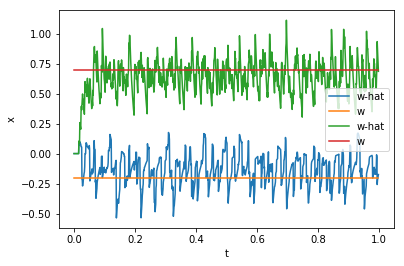

In [23]:
what=np.array(what)
w=np.array(w)

plt.plot(t,what[:,0],label='w-hat')
plt.plot(t,w[:,0],label='w')
plt.plot(t,what[:,1],label='w-hat')
plt.plot(t,w[:,1],label='w')
plt.xlabel('t')
plt.ylabel('x')
plt.legend()
plt.show()

<ol style="list-style:lower-alpha outside none;" start="2">
<li>[0.5 marks] Produce the same plot for $x=[0.5,1], y=[sin(4\pi t),0.3], z=[0.2,0.1], q = [sin(4\pi t),-0.2]$.</li>
</ol>

In [24]:
w = []
for val in t:
    w.append([x[0] -3*(np.sin(4*np.pi*val)) +2*z[0] -2*(np.sin(4*np.pi*val)), x[1] -3*y[1] +2*z[1] -2*q[1]])

In [25]:
Y=[]
for val in t:
    Y.append([np.sin(4*np.pi*val), y[1]])

spikes_y = []
for neuron in neurons_y:
    _, s = neuron.get_spikes(Y,dt)
    spikes_y.append(s)

filtered_spikes_y = [my_convolution(s, h) for s in spikes_y]
A = np.array(filtered_spikes_y).T
yhat = np.dot(A/dt,d_y)

In [26]:
Q=[]
for val in t:
    Q.append([np.sin(4*np.pi*val), q[1]])

spikes_q = []
for neuron in neurons_q:
    _, s = neuron.get_spikes(Q,dt)
    spikes_q.append(s)

filtered_spikes_q = [my_convolution(s, h) for s in spikes_q]
A = np.array(filtered_spikes_q).T
qhat = np.dot(A/dt,d_q)

In [27]:
neurons_w = [LIF2DNeuron() for _ in range(total_no_neurons)]
rates_w = [n.get_rates(points) for n in neurons_w]

A_w = np.transpose(rates_w)
g = np.dot(np.transpose(A_w),A_w)/number_of_samples + sigma*np.identity(A_w.shape[1])
u = np.dot(np.transpose(A_w),points)/number_of_samples
d_w = np.dot(np.linalg.inv(g),u)

xy = [p[0] + p[1] + p[2] + p[3] for p in zip(xhat,yhat,zhat,qhat)]
spikes_w = []
for neuron in neurons_w:
    _, s = neuron.get_spikes(xy,dt)
    spikes_w.append(s)

filtered_spikes_w = [my_convolution(s, h) for s in spikes_w]
A = np.array(filtered_spikes_w).T
what = np.dot(A/dt,d_w)

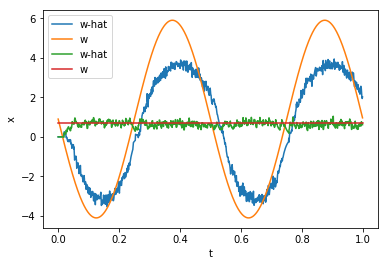

In [28]:
what=np.array(what)
w=np.array(w)

plt.plot(t,what[:,0],label='w-hat')
plt.plot(t,w[:,0],label='w')
plt.plot(t,what[:,1],label='w-hat')
plt.plot(t,w[:,1],label='w')
plt.xlabel('t')
plt.ylabel('x')
plt.legend()
plt.show()

<ol style="list-style:lower-alpha outside none;" start="3">
<li>[0.5 marks] Describe your results and discuss why and how they stray from the expected answer.</li></ol>

The above system represents the decoding of signals in more than one dimentions. The decoding starts from zero, which is real system. A real system doesn't have any value of signal at t equals to 0. Within a very short duration the decoding improves rapidly because of availability of new information for w signal. We can see the neurons gets saturated at high amplitude, they do not respond well on greater magnitude, which can be shown for sin curve. But for the linear line, its decoding is much better and the error is small. Also there is lag in decoding due to post synapic filter.